# Predicting AirBnB Rental Prices

## Introduction

In this project, the goal is to estimate the price of an AirBnB house using the neighborhood of the house, room-type that house is offering, review rates and availability. In order to do so, the relationship between each parameter and price was visually analyzed. Additionally, there exists a dataset that contains information about the museums in New York and another dataset that has the record of the complaints done to the NYPD in recent years. My intuition is that houses closer (latitude and longitude wise) to museums are popular and therefore they might be more expensive. Also, crime rates are used since people prefer crimeless neighborhoods.

##Outline

1.   Firstly, we'll explore the datasets mentioned above and make some necessary modifications on them.
2.   Then, we are going to reveal the relationships between price and several columns. For this purpose, we'll visualize the data and do some hypothesis testing.
3.   After first two steps, we'll create models wşth different machine learning algorithms and pick the most appropriate one.
4.   Finally, we'll evaluate the results and go back to previous steps to make some improvements if necessary.





## Description of the Datasets

### New York City Airbnb Open Data (https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data/data)

The main dataset that we'll be focusing on is the AirBnB dataset. This dataset is open source and it contains information on airbnb listings all over New York City. It has 48895 rows and 16 columns. Each row contains information about a single rental.

### NYC Museum Dataset (https://data.world/city-of-ny/ekax-ky3z)

Besides, there is the museum dataset which shows the spatial location, telephone numbers, addresses and website URLs of the New York state museums. We are only trying find a correlation between museums and airBnB locations, so we will remove the telephone number and URL columns. The data consists of 131 rows and 8 columns.

### NYPD Complaint Data Historic (https://data.cityofnewyork.us/Public-Safety/NYPD-Complaint-Data-Historic/qgea-i56i)

Additional to the datasets above, there is the complaint dataset which consists of 35 columns and 6 billion rows. Column names include information like the date and time of the complaint, which precinct it was made to, the type of the offense, the race, age and sex description of the victim and suspect. Since  calculating a correlation between location of the complaints and the location of the houses, we will ignore most of the information and only keep information about the location. Also, to eliminate complaints which are not actual crimes (just misdemeanors and violations) we will use the ‘type of the offense’ column and select the rows that are associated with felony crimes in the preprocessing section.

#Data Preprocessing

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

# to be used a prefix for all files
path_prefix = "/content/drive/My Drive"

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os.path import join

%matplotlib inline

Before we start, let's take a look at the AirBnB dataset.

In [ ]:
df = pd.read_csv(join(path_prefix, "AB_NYC_2019.csv"))
df.sample(5)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
6603,4774496,Five star large one bedroom!,24517455,Terry,Manhattan,Upper East Side,40.77792,-73.95390,Entire home/apt,185,1,121,2019-06-17,2.19,1,337
8926,6849332,"Clean, Convenient & Calming Space",973817,Carol,Manhattan,Washington Heights,40.85151,-73.93789,Entire home/apt,105,2,0,NaN,NaN,1,0
44441,34229313,Astoria's Retreat 10min away from the city. Prkg,247092108,Jackie,Queens,Astoria,40.76683,-73.91435,Entire home/apt,199,1,12,2019-07-06,7.06,3,283
525,190968,Lovely Brooklyn Brownstone 1BR!,922922,Karen,Brooklyn,Prospect Heights,40.67946,-73.96501,Entire home/apt,215,3,33,2019-05-08,0.35,1,156
16720,13373300,Sunny Apt in Historic Cobble Hill Brownstone,8190806,Lauren Wesley,Brooklyn,Cobble Hill,40.68850,-73.99443,Entire home/apt,175,5,53,2019-06-24,1.44,1,99


Now, we may drop some columns since they are about the identification of the rental, which is not our concern in this project.

In [ ]:
df.drop(['id', 'name', 'host_id', 'host_name', 'last_review'], axis=1, inplace=True)
df.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,1,365
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0


Now, let's deal with the NaN values.

In [ ]:
# check NaN distributions
df.isnull().mean()

neighbourhood_group               0.000000
neighbourhood                     0.000000
latitude                          0.000000
longitude                         0.000000
room_type                         0.000000
price                             0.000000
minimum_nights                    0.000000
number_of_reviews                 0.000000
reviews_per_month                 0.205583
calculated_host_listings_count    0.000000
availability_365                  0.000000
dtype: float64

In [ ]:
# fill the NaN values in reviews_per_month with the median of the column
df["reviews_per_month"].fillna(df["reviews_per_month"].median(), inplace=True)
df.isnull().mean()

neighbourhood_group               0.0
neighbourhood                     0.0
latitude                          0.0
longitude                         0.0
room_type                         0.0
price                             0.0
minimum_nights                    0.0
number_of_reviews                 0.0
reviews_per_month                 0.0
calculated_host_listings_count    0.0
availability_365                  0.0
dtype: float64

Let's examine the calculated host listings counts distribution.

count    48895.000000
mean         7.143982
std         32.952519
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max        327.000000
Name: calculated_host_listings_count, dtype: float64

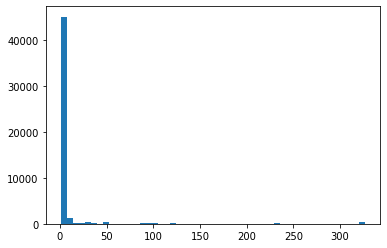

In [ ]:
# visualize calculated_host_listings_count distributions
plt.hist(df['calculated_host_listings_count'], bins=50)
df['calculated_host_listings_count'].describe()

We see that most of the host listings counts is between 0 and 3. So, we come up with the idea of categorizing this column. Our categories can be the following:

*   normal
*   a bit much
*   much
*   too much
*   excessive

In [ ]:
df['calculated_host_listings_count'][df['calculated_host_listings_count'] > 14].describe()

count    2477.000000
mean      107.127574
std       104.136382
min        15.000000
25%        31.000000
50%        52.000000
75%       121.000000
max       327.000000
Name: calculated_host_listings_count, dtype: float64

In [ ]:
# categorize rentals in terms of calculated_host_listings_count values
def categorize_host_listings_count(count):
  if count > 0 and count <= 5:
    return 'normal'
  elif count <= 15:
    return 'a bit much'
  elif count <= 52:
    return 'much'
  elif count <= 121:
    return 'too much'
  elif count <= 327:
    return 'excessive'
  else:
    return 'missing'

df['listing_degree'] = df['calculated_host_listings_count'].apply(categorize_host_listings_count)
df['listing_degree'].value_counts()

normal        44099
a bit much     2394
much           1184
too much        659
excessive       559
Name: listing_degree, dtype: int64

Here is the distribution of listing degrees.

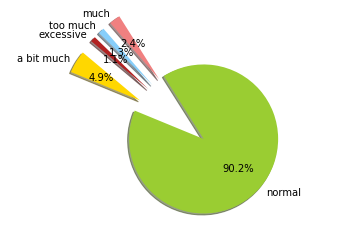

In [ ]:
sizes = [df[df["listing_degree"]== "a bit much"]["listing_degree"].count(), df[df["listing_degree"]== "normal"]["listing_degree"].count(), df[df["listing_degree"]== "much"]["listing_degree"].count() , df[df["listing_degree"]== "too much"]["listing_degree"].count(), df[df["listing_degree"]== "excessive"]["listing_degree"].count()]
labels = df["listing_degree"].unique() 
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'firebrick']
explode = (1,0,1,1,1)  # explode 1st slice

plt.pie(sizes, explode = explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

At this step, we are going to utilize the museum dataset. First, let's have a look at it.

In [ ]:
# read nyc museum data
museum_df = pd.read_csv(join(path_prefix, 'new-york-city-museums-2.csv'))
museum_df.head()

,the_geom,NAME,TEL,URL,ADRESS1,ADDRESS2,CITY,ZIP
0,POINT (-74.01375579519738 40.703816216918035),Alexander Hamilton U.S. Custom House,(212) 514-3700,http://www.oldnycustomhouse.gov/,1 Bowling Grn,NaN,New York,10004
1,POINT (-74.06303178855111 40.615120837755356),Alice Austen House Museum,(718) 816-4506,http://www.aliceausten.org/,2 Hylan Blvd,NaN,Staten Island,10305
2,POINT (-73.94729768541572 40.833853500753314),American Academy of Arts and Letters,(212) 368-5900,http://www.artsandletters.org/,633 W. 155th St.,NaN,New York,10032
3,POINT (-73.97810302110001 40.76162497138548),American Folk Art Museum,(212) 265-1040,http://www.folkartmuseum.org/,45 West 53rd Street,NaN,New York,10019
4,POINT (-74.0396848374904 40.69905626244391),American Immigration History Center,(212) 363-3200,http://www.ellisisland.org/,Ellis Island,NaN,New York,0


'the_geom' column is the (latitude, longitude) values of the museums. We may use this column for visualizing the locations of the museums with the help of a map.

In [ ]:
def clean_the_geom(point):
  first_pharantesis = point.index('(')
  space = point.index(' ', first_pharantesis)
  second_pharantesis = point.index(')')
  lat = float(point[first_pharantesis + 1 : space])
  lon = float(point[space + 1 : second_pharantesis])
  return (lat,lon)
museum_df['museum coordinates'] = museum_df['the_geom'].apply(clean_the_geom)
museum_df['museum coordinates']

0      (-74.01375579519738, 40.703816216918035)
1      (-74.06303178855111, 40.615120837755356)
2      (-73.94729768541572, 40.833853500753314)
3       (-73.97810302110001, 40.76162497138548)
4        (-74.0396848374904, 40.69905626244391)
                         ...                   
125     (-73.99388579658319, 40.73807723317813)
126     (-73.99379427245329, 40.73795994708654)
127    (-73.99392890421056, 40.738015384101416)
128       (-73.99381737049632, 40.738045683847)
129    (-73.99386877223978, 40.737986764588406)
Name: museum coordinates, Length: 130, dtype: object

In [ ]:
# heat map of museums
import folium
from folium.plugins import HeatMap
hm = folium.Map()
HeatMap(museum_df['museum coordinates']).add_to(hm)
hm

From the heat map, wee see that the latitudes and longitudes are showing some irrelevant location. After several attempts, it turns out to be that latitudes and longitudes of a location are inversed.

We assume that the dataset contains wrong information. So, we conclude that we won't use 'the_geom' column. Instead, we may utilize the 'ADRESS1' and 'ADRESS2' columns for detecting the location of the museums.

In [ ]:
def fix_inversion(point):
  return (point[1], point[0])
museum_df['museum coordinates'] = museum_df['museum coordinates'].apply(fix_inversion)
museum_df['museum coordinates']

0      (40.703816216918035, -74.01375579519738)
1      (40.615120837755356, -74.06303178855111)
2      (40.833853500753314, -73.94729768541572)
3       (40.76162497138548, -73.97810302110001)
4        (40.69905626244391, -74.0396848374904)
                         ...                   
125     (40.73807723317813, -73.99388579658319)
126     (40.73795994708654, -73.99379427245329)
127    (40.738015384101416, -73.99392890421056)
128       (40.738045683847, -73.99381737049632)
129    (40.737986764588406, -73.99386877223978)
Name: museum coordinates, Length: 130, dtype: object

In [ ]:
hm = folium.Map()
HeatMap(museum_df['museum coordinates']).add_to(hm)
hm

Now, let's calculate the number of museums that are at most 2 km far away from the rental and add this number to our dataframe as a new feature.

In [ ]:
import geopy.distance
def find_near_museums(lat, lon):
  rental_loc = (lat, lon)
  cnt = 0
  for museum in museum_df['museum coordinates']:
    if geopy.distance.vincenty(rental_loc, museum).km <= 2:
      cnt += 1
  return cnt

In [ ]:
df['near_museums_num'] = df.apply(lambda x: find_near_museums(x.latitude, x.longitude), axis=1)
df['near_museums_num'].describe()

count    48895.000000
mean         8.233419
std          9.255380
min          0.000000
25%          0.000000
50%          4.000000
75%         18.000000
max         32.000000
Name: near_museums_num, dtype: float64

For this purpose, let's look at the neighborhood groups we have in New York.

In [ ]:
# neighborhood groups in df
df['neighbourhood_group'].unique()

array(['Brooklyn', 'Manhattan', 'Queens', 'Staten Island', 'Bronx'],
      dtype=object)

Then, we deal with NaN values.

In [ ]:
museum_df['ADDRESS2'].fillna('', inplace=True)
museum_df['ADDRESS2'][museum_df['ADDRESS2'] != '']

6                                             11th Floor
8                                              5th Floor
11                                       Pelham Bay Park
37                                      Carl Schurz Park
47                            75 Varick Street 2nd Floor
54     Fiorello H. LaGuardia Community College/CUNY R...
55                                             Suite 301
56       Flatbush and Ocean Avenues and Empire Boulevard
65                                             3rd Floor
71                                             Suite 401
80                                            20th Floor
96                          Flushing Meadows Corona Park
107                                           Sony Plaza
114                                             Suite 2D
120                        Broadway at West 246th Street
Name: ADDRESS2, dtype: object

At this point, we see that there is the floor information of some museums in 'ADDRESS2' column. We think that it may confuse the geocoder since it is too specific. So, we remove it.

In [ ]:
def remove_floor(adress2):
  if adress2 != '':
    try:
      floor = adress2.index('11th Floor')
      adress2 = (adress2[:floor]).strip()
    except:
      try:
        floor = adress2.index('5th Floor')
        adress2 = ''
      except:
        try:
          floor = adress2.index('2nd Floor')
          adress2 = (adress2[:floor]).strip()
        except:
          try:
            floor = adress2.index('3rd Floor')
            adress2 = ''
          except:
            try:
              floor = adress2.index('20th Floor')
              adress2 = ''
            except:
              pass
  return adress2
museum_df['ADDRESS2'] = museum_df['ADDRESS2'].apply(remove_floor)
museum_df['ADDRESS2'][museum_df['ADDRESS2'] != '']

11                                       Pelham Bay Park
37                                      Carl Schurz Park
47                                      75 Varick Street
54     Fiorello H. LaGuardia Community College/CUNY R...
55                                             Suite 301
56       Flatbush and Ocean Avenues and Empire Boulevard
71                                             Suite 401
96                          Flushing Meadows Corona Park
107                                           Sony Plaza
114                                             Suite 2D
120                        Broadway at West 246th Street
Name: ADDRESS2, dtype: object

Now, let's merge the columns 'ADRESS1' and 'ADRESS2' in order to have a full, single adress.

In [ ]:
museum_df['adress'] = museum_df['ADRESS1'] + ' ' + museum_df['ADDRESS2']
museum_df['adress'][museum_df['ADDRESS2'] != '']

11                        895 Shore Road Pelham Bay Park
37       89th Street at East End Avenue Carl Schurz Park
47                      1 Hudson Square 75 Varick Street
54     31-10 Thomson Ave. Fiorello H. LaGuardia Commu...
55                          2 West 32nd Street Suite 301
56     Prospect Park Willink Entrance Flatbush and Oc...
71                                594 Broadway Suite 401
96     Queens Museum of Art Flushing Meadows Corona Park
107                           550 Madison Ave Sony Plaza
114                         104 E. 126th Street Suite 2D
120    VAN CRTLANDT MANSION Broadway at West 246th St...
Name: adress, dtype: object

Then, we extract the neighborhood groups out of adresses. To do this, first we get the detailed adress by utilizing geopy's geocoders framework.

In [ ]:
# get the full adress and find the neighborhood group out of it
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="my_application")
def assign_to_neighborhood(short_adress):
  location = geolocator.geocode(short_adress, timeout=40)
  boros = {'Brooklyn', 'Manhattan', 'Queens', 'Staten Island', 'Bronx'}
  if location != None:
    full_adress = location.address
    full_adress = full_adress.split(',')
    full_adress_strip = [b.strip() for b in full_adress]
    for boro in boros:
      if boro in full_adress_strip:
        return boro
  return 'Other'
museum_df['neighbor'] = museum_df['adress'].apply(assign_to_neighborhood)
museum_df['neighbor']

0      Other
1      Other
2      Other
3      Other
4      Other
       ...  
125    Other
126    Other
127    Other
128    Other
129    Other
Name: neighbor, Length: 130, dtype: object

The next step we will take is assigning the number of museums in the neighborhoods to the rentals.

neighbor
Brooklyn         12
Manhattan        14
Other            92
Queens            7
Staten Island     5
Name: the_geom, dtype: int64

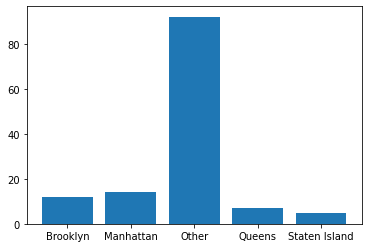

In [ ]:
# plot a bar chart which shows the number of museums in each neighborhood group
museum_counts = museum_df.groupby('neighbor').count()
museum_counts = museum_counts.iloc[:,0]
plt.bar(museum_counts.keys(), museum_counts)
museum_counts

In [ ]:
# assign museum counts to rentals with respect to the number of museums in the neighborhood group they belong to
def return_museum_count(neighbor):
  # if 'Bronx'
  if neighbor not in museum_counts.keys():
    return 0
  else:
    return museum_counts[neighbor]
df['museum_count'] = df['neighbourhood_group'].apply(return_museum_count)
df['museum_count']

0        12
1        14
2        14
3        12
4        14
         ..
48890    12
48891    12
48892    14
48893    14
48894    14
Name: museum_count, Length: 48895, dtype: int64

Finally, we nomalize the museum counts.

In [ ]:
# normalize museum counts
def normalize(x):
  min = x.min()
  max = x.max()
  return (x - min) / (max - min)
df['museum_count'] = normalize(df['museum_count'])
df['museum_count'].describe()

count    48895.000000
mean         0.856104
std          0.205236
min          0.000000
25%          0.857143
50%          0.857143
75%          1.000000
max          1.000000
Name: museum_count, dtype: float64

Now, let's analyze the complaint data.

In [ ]:
# read nyc complaint data
complaint_df = pd.read_csv(join(path_prefix, 'NYPD_Complaint_Data_Historic.csv'))
complaint_df.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,CRM_ATPT_CPTD_CD,LAW_CAT_CD,BORO_NM,LOC_OF_OCCUR_DESC,PREM_TYP_DESC,JURIS_DESC,JURISDICTION_CODE,PARKS_NM,HADEVELOPT,HOUSING_PSA,X_COORD_CD,Y_COORD_CD,SUSP_AGE_GROUP,SUSP_RACE,SUSP_SEX,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX
0,522575447,08/29/2006,13:00:00,NaN,NaN,43.0,08/30/2006,578.0,HARRASSMENT 2,638.0,"HARASSMENT,SUBD 3,4,5",COMPLETED,VIOLATION,BRONX,INSIDE,RESIDENCE - APT. HOUSE,N.Y. POLICE DEPT,0.0,NaN,NaN,NaN,1018029.0,240747.0,NaN,UNKNOWN,M,NaN,40.827414,-73.877946,"(40.827414051, -73.877945775)",PATROL BORO BRONX,NaN,25-44,BLACK HISPANIC,F
1,403507361,11/05/2006,11:00:00,11/05/2006,17:40:00,66.0,11/05/2006,107.0,BURGLARY,221.0,"BURGLARY,RESIDENCE,DAY",COMPLETED,FELONY,BROOKLYN,INSIDE,RESIDENCE - APT. HOUSE,N.Y. POLICE DEPT,0.0,NaN,NaN,NaN,982556.0,171385.0,NaN,NaN,NaN,NaN,40.637097,-74.006105,"(40.637096864, -74.006105014)",PATROL BORO BKLYN SOUTH,NaN,45-64,ASIAN / PACIFIC ISLANDER,F
2,631420068,09/08/2006,23:30:00,09/09/2006,00:01:00,106.0,09/09/2006,347.0,INTOXICATED & IMPAIRED DRIVING,905.0,"INTOXICATED DRIVING,ALCOHOL",COMPLETED,MISDEMEANOR,QUEENS,FRONT OF,STREET,N.Y. POLICE DEPT,0.0,NaN,NaN,NaN,1028213.0,186786.0,NaN,NaN,NaN,NaN,40.679260,-73.841500,"(40.679260229, -73.841500185)",PATROL BORO QUEENS SOUTH,NaN,NaN,UNKNOWN,E
3,995609899,12/13/2011,18:40:00,12/13/2011,18:49:00,79.0,12/13/2011,341.0,PETIT LARCENY,333.0,"LARCENY,PETIT FROM STORE-SHOPL",COMPLETED,MISDEMEANOR,BROOKLYN,INSIDE,CHAIN STORE,N.Y. POLICE DEPT,0.0,NaN,NaN,NaN,1000788.0,189718.0,NaN,NaN,NaN,NaN,40.687402,-73.940369,"(40.687401619, -73.940369194)",PATROL BORO BKLYN NORTH,NaN,NaN,UNKNOWN,D
4,480667624,08/14/2009,04:20:00,NaN,NaN,30.0,08/14/2009,113.0,FORGERY,729.0,"FORGERY,ETC.,UNCLASSIFIED-FELO",COMPLETED,FELONY,MANHATTAN,NaN,STREET,N.Y. POLICE DEPT,0.0,NaN,NaN,NaN,1000029.0,242245.0,NaN,NaN,NaN,NaN,40.831576,-73.942983,"(40.831576128, -73.942982699)",PATROL BORO MAN NORTH,NaN,NaN,UNKNOWN,E


Below, we see that there are three types of complaints. We may only mind felonies since the other may not be intimidating for the customers. So, we seperate those complaints from complaint_df.

In [ ]:
complaint_df['LAW_CAT_CD'].unique()

array(['VIOLATION', 'FELONY', 'MISDEMEANOR', nan], dtype=object)

In [ ]:
felonies = complaint_df[complaint_df['LAW_CAT_CD'] == 'FELONY']
felonies['LAW_CAT_CD'].describe()

count     304946
unique         1
top       FELONY
freq      304946
Name: LAW_CAT_CD, dtype: object

In [ ]:
# drop NaN values
felonies['BORO_NM'].dropna(inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:4494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(result)


Now, we group complaints by the boroughs (same with the neighbourhood_group column in the AirBnB dataset in terms of unique values) and visualize the number of complaints made in different boroughs.

In [ ]:
# group complaints by boroughs
complaint_regions = complaint_df.groupby('BORO_NM').count().iloc[:,0]
complaint_regions

BORO_NM
BRONX            216685
BROOKLYN         293931
MANHATTAN        238427
QUEENS           193742
STATEN ISLAND     48356
Name: CMPLNT_NUM, dtype: int64

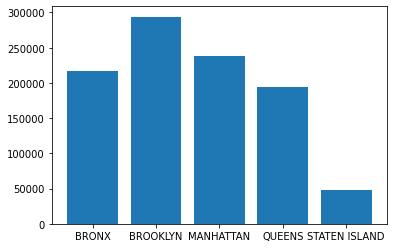

In [ ]:
# plot a bar chart which displays the number of felony degree complaints in each region
plt.bar(complaint_regions.keys(), complaint_regions)
plt.show()

Total number of complaints can be misleading, since there the number of people living in the boros may differ. Thus, let's calculate the number of complaint per capita.

In [ ]:
# populations of boros
populations = {
    'BRONX': 1418207,
    'BROOKLYN': 2559903,
    'MANHATTAN': 1628706,
    'QUEENS': 2253858,
    'STATEN ISLAND': 476143
    }

Here, we assign complaints in the region per capita to rentals.

In [ ]:
def return_complaints_num(neighborhood):
  n = neighborhood.upper()
  return float(complaint_regions[n]) / populations[n]
df['complaints'] = df['neighbourhood_group'].apply(return_complaints_num)
df['complaints'].describe()

count    48895.000000
mean         0.126208
std          0.021021
min          0.085960
25%          0.114821
50%          0.114821
75%          0.146390
max          0.152788
Name: complaints, dtype: float64

Then, we do normalization on the number of complaints.

In [ ]:
df['complaints'] = normalize(df['complaints'])
df['complaints'].describe()

count    48895.000000
mean         0.602265
std          0.314556
min          0.000000
25%          0.431871
50%          0.431871
75%          0.904268
max          1.000000
Name: complaints, dtype: float64

We have finished the preprocessing. Let's take a final look at the AirBnB dataset.

In [ ]:
df.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,listing_degree,near_museums_num,museum_count,complaints
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365,a bit much,0,0.857143,0.431871
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355,normal,30,1.000000,0.904268
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,0.72,1,365,normal,4,1.000000,0.904268
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194,normal,3,0.857143,0.431871
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0,normal,7,1.000000,0.904268


# Relationships between Features and Price

In this section of the project, we will focus on revealing the relationships of price and other columns that we think could be relevant.

### Room Type vs Price

In [ ]:
df['room_type'].unique()

array(['Private room', 'Entire home/apt', 'Shared room'], dtype=object)

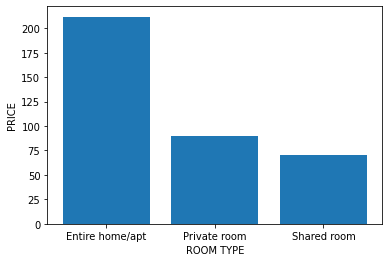

In [ ]:
room_price = df.groupby('room_type').price.mean()
plt.bar(room_price.keys(), room_price.values)
plt.ylabel('PRICE')
plt.xlabel('ROOM TYPE')
plt.show()

We see that entire homes and apartments are much more expensive than private rooms and shared rooms.

Accordingly, we select form our hyptohesis as the following:

$\mu_{ent}$: avg. price of entire homes or apartments
$\mu_{shr}$: avg. price of shared rooms

$H_0: \mu_{ent} = \mu_{shr}$ (Null Hypothesis)

$H_A: \mu_{ent} > \mu_{shr}$ (Alternative Hypothesis)

Then, we conduct a one-tailed T test to decide whether to reject or not reject our hypothesis.


In [ ]:
from scipy import stats
test_result = stats.ttest_ind(df[df["room_type"]== "Entire home/apt"]["price"] , df[df["room_type"]== "Shared room"]["price"], equal_var=False)  # since we have not equal variances
p_value = test_result.pvalue
reject = p_value/2 <= 0.05
print("Pvalue is", p_value)
print("Do i reject the null hypothesis? ---->", reject)

Pvalue is 2.1450514526886765e-268
Do i reject the null hypothesis? ----> True


Since p-value we found is smaller than $\alpha = 0.05$, we reject the null hypothesis. It means that entire homes or apartments have higher prices than shared rooms with a 95 percent confidence level.

### Number of Reviews vs Price

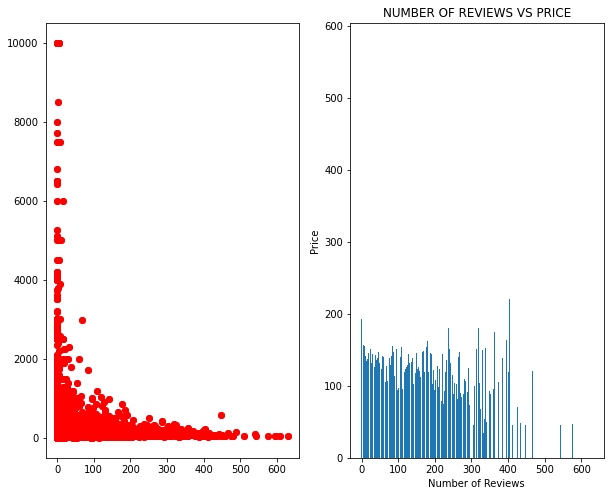

In [ ]:
# NUMBER OF REVIEWS VS PRICE
fig, axes = plt.subplots(1, 2, figsize=(10,8))
axes[0].scatter(x=df['number_of_reviews'],y=df['price'],color='red')
plt.title('NUMBER OF REVIEWS VS PRICE')
axes[0].scatter(x=df['number_of_reviews'],y=df['price'],color='red')
review_prices = df.groupby('number_of_reviews').mean()['price']
axes[1].bar(review_prices.keys(), review_prices)
plt.xlabel('Number of Reviews')
plt.ylabel('Price')
plt.show()

In [ ]:
# HYPOTHESIS TESTING
stats.pearsonr(df["number_of_reviews"], df["price"])

(-0.04795422658266221, 2.689737394103427e-26)

As the correlation coefficient, we obtained -0.04795422658266221 which states that the correlation between number of reviews and price is not signficant. Indeed, we would expect a direct proportion(positive association). From the p-value, less than the significance level, we can see that our correlation coefficient is reliable.

### Minimum Nights Required vs Price

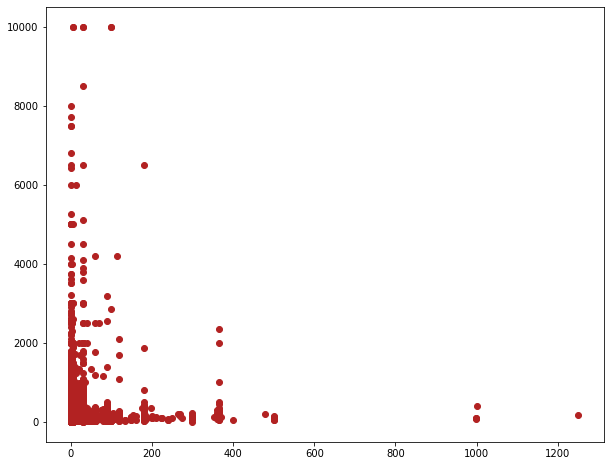

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10,8))
plt.scatter(x=df['minimum_nights'],y=df['price'],color='firebrick')
plt.show()

In [ ]:
stats.pearsonr(df["minimum_nights"], df["price"])

(0.04279933414330346, 2.8531707312205514e-21)

As the correlation coefficient, we obtained 0.04279933414330346 which states that the correlation between number of reviews and price is not signficant. Indeed, we would expect a positive association. From the p-value, less than the significance level, we can see that our test is significant.

###Number of Available Days in a Year vs Price

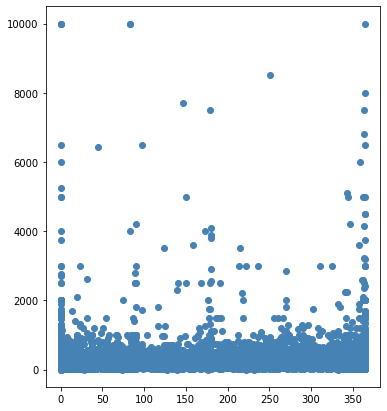

In [ ]:
fig, ax= plt.subplots(1, 1, figsize=(6,7))
plt.scatter(x=df['availability_365'],y=df['price'],color='steelblue')
plt.show()

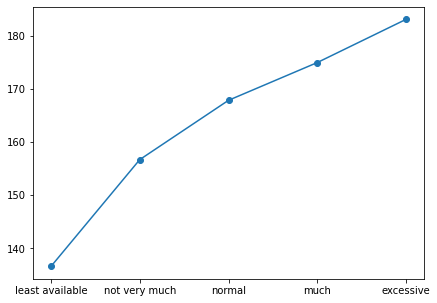

In [ ]:
def categorize_availability(count):
  if count >= 0 and count <= 73:
    return 'least available'
  elif count >= 74 and count <= 146:
    return 'not very much'
  elif count >= 147 and count <= 219:
    return 'normal'
  elif count >= 220 and count <= 292:
    return 'much'
  elif count >= 293 and count <= 365:
    return 'excessive'

df['avaCat'] = df['availability_365'].apply(categorize_availability)
ava = [df[df["avaCat"]== "least available"]["price"].mean(), df[df["avaCat"]== "not very much"]["price"].mean() , df[df["avaCat"]== "normal"]["price"].mean(),df[df["avaCat"]== "much"]["price"].mean(),df[df["avaCat"]== "excessive"]["price"].mean()]
fig, ax= plt.subplots(1, 1, figsize=(7,5))
cat = ["least available","not very much","normal","much","excessive"]
plt.plot(cat,ava, marker='o')
plt.show()

###Listing Degree vs Price


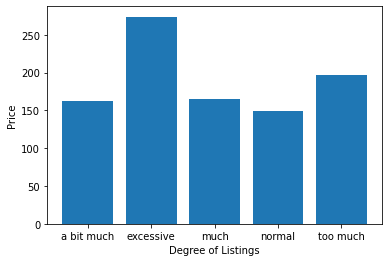

In [ ]:
listing_price = df.groupby('listing_degree').mean()['price']
plt.bar(listing_price.keys(), listing_price)
plt.xlabel('Degree of Listings')
plt.ylabel('Price')
plt.show()

We observe that *'excessive'* degree listings have higher prices in average. Meanwhile, there is no significant difference between other degree of listings.

###Neighborhood Group vs Price

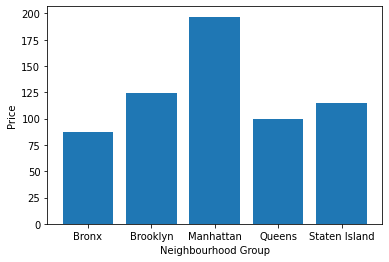

In [ ]:
neighborhood_price = df.groupby('neighbourhood_group').mean()['price']
plt.bar(neighborhood_price.keys(), neighborhood_price)
plt.xlabel('Neighbourhood Group')
plt.ylabel('Price')
plt.show()

We observe that the rentals in *Manhattan* are more expensive than any other borough in average. But, there is no significant difference between other neighborhood groups.

###Number of Museums in the Region vs Price

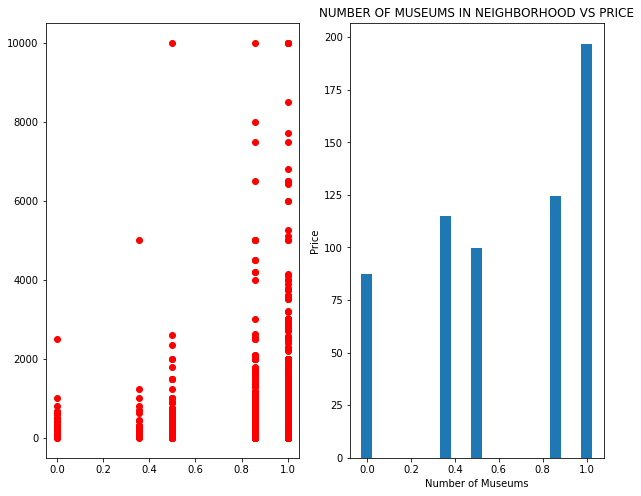

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10,8))
axes[0].scatter(x=df['museum_count'],y=df['price'],color='red')
plt.title('NUMBER OF MUSEUMS IN NEIGHBORHOOD VS PRICE')
museum_prices = df.groupby('museum_count').mean()['price']
axes[1].bar(museum_prices.keys(), museum_prices, width=0.05)
plt.xlabel('Number of Museums')
plt.ylabel('Price')
plt.show()

In [ ]:
stats.pearsonr(df["museum_count"], df["price"])

(0.1296143908500003, 3.671126905613877e-182)

As the correlation coefficient, we obtained 0.09068739910283724 which states that the correlation between number of reviews and price is not very signficant but it is possible that it has an effect on price. From the p-value, less than the significance level, we can see that our test is significant.

###Number of Complaints in the Region vs Price

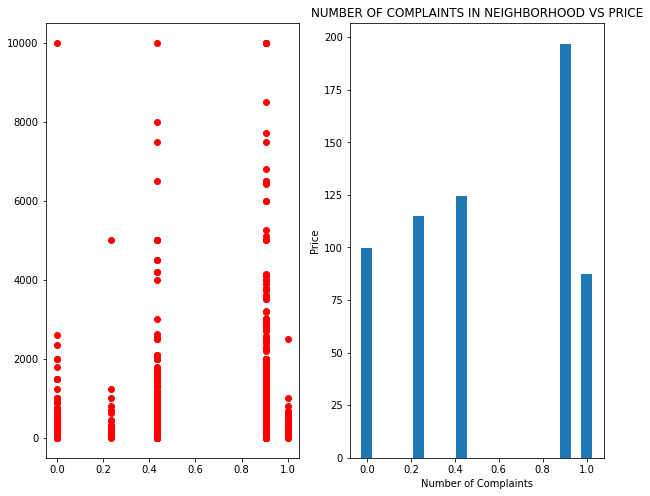

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10,8))
axes[0].scatter(x=df['complaints'],y=df['price'],color='red')
plt.title('NUMBER OF COMPLAINTS IN NEIGHBORHOOD VS PRICE')
complaint_prices = df.groupby('complaints').mean()['price']
axes[1].bar(complaint_prices.keys(), complaint_prices, width=0.05)
plt.xlabel('Number of Complaints')
plt.ylabel('Price')
plt.show()

In [ ]:
stats.pearsonr(df["complaints"], df["price"])

(0.14738866487169427, 1.6194057534895734e-235)

As the correlation coefficient, we obtained 0.14738866487169427 which states that the correlation between number of reviews and price is not signficant. Indeed, we would expect a inverse proportion. From the p-value, less than the significance level, we can see that our test is significant.

# Feature Engineering
We did some preprocessing on the Data Preprocessing section. Now we will apply some feature engineering methods to use the data as input to our machine learning models.

First, let's look at the current state of our dataframe.

In [ ]:
df.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,listing_degree,near_museums_num,museum_count,complaints,avaCat
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365,a bit much,0,0.857143,0.431871,excessive
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355,normal,30,1.000000,0.904268,excessive
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,0.72,1,365,normal,4,1.000000,0.904268,excessive
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194,normal,3,0.857143,0.431871,normal
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0,normal,7,1.000000,0.904268,least available


In [ ]:
from sklearn.preprocessing import OneHotEncoder

# limit to categorical data using df.select_dtypes()
categorical_features = df.select_dtypes(include=[object])
categorical_features.head()

,neighbourhood_group,neighbourhood,room_type,listing_degree,avaCat
0,Brooklyn,Kensington,Private room,a bit much,excessive
1,Manhattan,Midtown,Entire home/apt,normal,excessive
2,Manhattan,Harlem,Private room,normal,excessive
3,Brooklyn,Clinton Hill,Entire home/apt,normal,normal
4,Manhattan,East Harlem,Entire home/apt,normal,least available


In [ ]:
enc = OneHotEncoder()
enc.fit(categorical_features)
one_hot_labels = enc.transform(categorical_features).toarray()
one_hot_labels
df2 = pd.DataFrame(one_hot_labels)
df2.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
enc.get_feature_names(['neighbourhood_group', 'neighbourhood', 'room_type', 'listing_degree', 'avaCat'])

array(['neighbourhood_group_Bronx', 'neighbourhood_group_Brooklyn',
       'neighbourhood_group_Manhattan', 'neighbourhood_group_Queens',
       'neighbourhood_group_Staten Island', 'neighbourhood_Allerton',
       'neighbourhood_Arden Heights', 'neighbourhood_Arrochar',
       'neighbourhood_Arverne', 'neighbourhood_Astoria',
       'neighbourhood_Bath Beach', 'neighbourhood_Battery Park City',
       'neighbourhood_Bay Ridge', 'neighbourhood_Bay Terrace',
       'neighbourhood_Bay Terrace, Staten Island',
       'neighbourhood_Baychester', 'neighbourhood_Bayside',
       'neighbourhood_Bayswater', 'neighbourhood_Bedford-Stuyvesant',
       'neighbourhood_Belle Harbor', 'neighbourhood_Bellerose',
       'neighbourhood_Belmont', 'neighbourhood_Bensonhurst',
       'neighbourhood_Bergen Beach', 'neighbourhood_Boerum Hill',
       'neighbourhood_Borough Park', 'neighbourhood_Breezy Point',
       'neighbourhood_Briarwood', 'neighbourhood_Brighton Beach',
       'neighbourhood_Bronxdale',

In [ ]:
df = df.join(df2)
df.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,listing_degree,near_museums_num,museum_count,complaints,avaCat,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,...,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365,a bit much,0,0.857143,0.431871,excessive,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355,normal,30,1.000000,0.904268,excessive,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,0.72,1,365,normal,4,1.000000,0.904268,excessive,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194,normal,3,0.857143,0.431871,normal,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0,normal,7,1.000000,0.904268,least available,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
df.drop(['neighbourhood_group', 'neighbourhood', 'room_type', 'listing_degree', 'avaCat', 'museum_count', 'avalability_365'], axis=1, inplace=True)
df.head()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,near_museums_num,complaints,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,...,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238
0,40.64749,-73.97237,149,1,9,0.21,6,365,0,0.431871,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,40.75362,-73.98377,225,1,45,0.38,2,355,30,0.904268,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,40.80902,-73.94190,150,3,0,0.72,1,365,4,0.904268,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3,40.68514,-73.95976,89,1,270,4.64,1,194,3,0.431871,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,40.79851,-73.94399,80,10,9,0.10,1,0,7,0.904268,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features = ["availability_365", "calculated_host_listings_count", "number_of_reviews","minimum_nights","complaints", "near_museums_num"]
df[features] = scaler.fit_transform(df[features])

In [ ]:
df.head()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,near_museums_num,complaints,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,...,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238
0,40.64749,-73.97237,149,-0.293996,-0.320414,0.21,-0.034716,1.916250,-0.889591,-0.541703,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,40.75362,-73.98377,225,-0.293996,0.487665,0.38,-0.156104,1.840275,2.351800,0.960103,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,40.80902,-73.94190,150,-0.196484,-0.522433,0.72,-0.186451,1.916250,-0.457405,0.960103,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3,40.68514,-73.95976,89,-0.293996,5.538156,4.64,-0.186451,0.617065,-0.565452,-0.541703,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,40.79851,-73.94399,80,0.144807,-0.320414,0.10,-0.186451,-0.856865,-0.133266,0.960103,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


Now that, we are done with the longitude and latitude features, we can drop those columns.

In [ ]:
df.drop(['latitude', 'longitude'], axis=1, inplace=True)
df.head()

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,near_museums_num,complaints,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,...,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238
0,149,-0.293996,-0.320414,0.21,-0.034716,-0.889591,-0.541703,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,225,-0.293996,0.487665,0.38,-0.156104,2.351800,0.960103,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,150,-0.196484,-0.522433,0.72,-0.186451,-0.457405,0.960103,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3,89,-0.293996,5.538156,4.64,-0.186451,-0.565452,-0.541703,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,80,0.144807,-0.320414,0.10,-0.186451,-0.133266,0.960103,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


# Machine Learning Methods

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from pprint import pprint

## Linear Regression

Our first try will be linear regression since it is very easy to implement and the interpretation of the equation is straightforward. We are expecting linear relationships between price and availabilty_365, listing_degree, neighborhood_group and room_type. We will do multiple regresssion combining all of these features.

In [ ]:
features = ["calculated_host_listings_count", "number_of_reviews","minimum_nights","near_museums_num","complaints"]
x = df[features].values
y = df['price'].values
x_remaining, x_test, y_remaining, y_test = train_test_split(x, y, random_state=1, test_size=0.15)
x_train, x_validation, y_train, y_validation = train_test_split(x_remaining, y_remaining, random_state=1, test_size=0.105)
mulreg = LinearRegression()
mulreg.fit(x_train, y_train)

y_pred = mulreg.predict(x_validation)
mse = mean_squared_error(y_validation, y_pred)
mae= (mean_absolute_error(y_validation, y_pred))
rmse = (np.sqrt(mse))
r2 = r2_score(y_validation, y_pred)

print('RMSE:', rmse)
print('MAE:', mae)
print('R2:', r2)
coeff_df = pd.DataFrame(mulreg.coef_, features, columns=['coefficient'])  
coeff_df

RMSE: 281.4363275139665
MAE: 86.49704858551114
R2: 0.032312520874038575


,coefficient
calculated_host_listings_count,3.532854
number_of_reviews,-8.194903
minimum_nights,2.589399
near_museums_num,52.948920
complaints,-2.493449


## Support Vector Machine

Now that we are done with linear regression, we will use SVM for our prediction. In order to do that we will use both linear and non-linear kernels since visualizations didn't give us any clues about the kernel. We will cover all areas.

In [ ]:
#Splitting the data
features = ["availability_365", "calculated_host_listings_count", "number_of_reviews","minimum_nights","museum_count","complaints"]
x = df[features].values
y = df['price'].values
x_remaining, x_test, y_remaining, y_test = train_test_split(x, y, random_state=1, test_size=0.15)
x_train, x_validation, y_train, y_validation = train_test_split(x_remaining, y_remaining, random_state=1, test_size=0.105)

print(len(x), len(y))
print(type(x), type(y))

48895 48895
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [ ]:
#We will use radial basis function, linear and polynomial kernels.
#RBF
svr_rbf = SVR(kernel='rbf')
svr_rbf.fit(x_train,y_train)
pred_rbf = svr_rbf.predict(x_validation)
 

In [ ]:
#linear
svr_lin = SVR(kernel='linear')
svr_lin.fit(x_train, y_train)
pred_lin = svr_lin.predict(x_validation)

In [ ]:
#Polynomial
svr_poly = SVR(kernel='poly', degree=3, epsilon=.1)
svr_poly.fit(x_train, y_train)
pred_poly = svr_poly.predict(x_validation)


Text(0.5, 1.0, 'Linear')

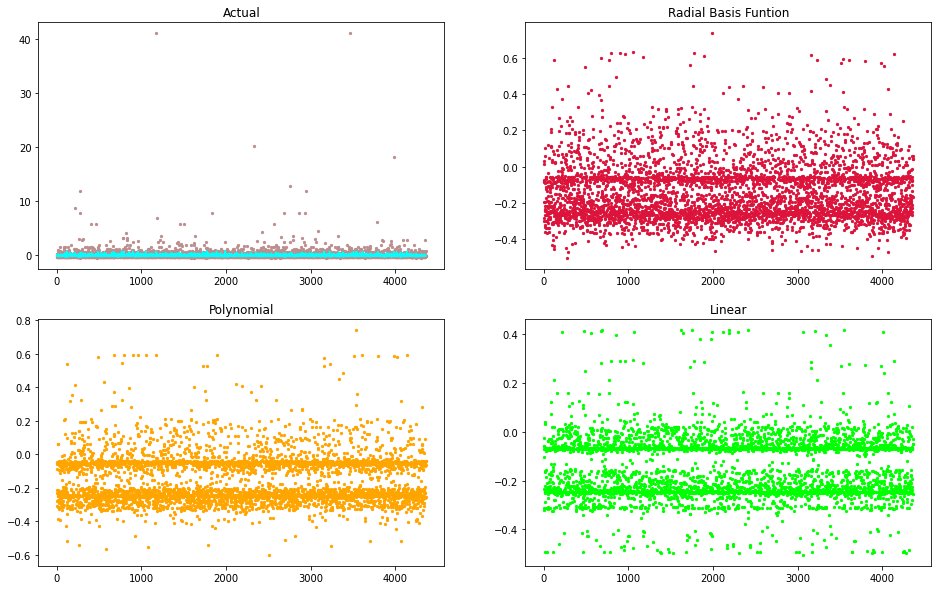

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16,10))
axes[0][0].scatter(x=np.arange(y_validation.size), y=y_validation, s=5, color = 'rosybrown')
axes[0][1].scatter(x=np.arange(y_validation.size), y=pred_rbf, s=5, color = 'crimson')
axes[0][0].plot(np.arange(y_validation.size),pred_rbf, color = 'aqua')
axes[1][0].scatter(x=np.arange(y_validation.size), y=pred_poly, s=5, color = 'orange')
axes[1][1].scatter(x=np.arange(y_validation.size), y=pred_lin, s=5, color = 'lime')

axes[0][0].set_title('Actual')
axes[0][1].set_title('Radial Basis Funtion') 
axes[1][0].set_title('Polynomial')
axes[1][1].set_title('Linear') 
 

### Error Rates

In [ ]:
print("----RBF----")
rmse = np.sqrt(mean_squared_error(y_validation, pred_rbf))
mae = mean_absolute_error(y_validation, pred_rbf)
print('Root Mean Squared Error:', rmse, 'Mean Absolute Error:', mae)

print("----Linear----")
rmse = np.sqrt(mean_squared_error(y_validation, pred_lin))
mae = mean_absolute_error(y_validation, pred_lin)
print('Root Mean Squared Error:', rmse, 'Mean Absolute Error:', mae)

print("----Polynomial----")
rmse = np.sqrt(mean_squared_error(y_validation, pred_poly))
mae = mean_absolute_error(y_validation, pred_poly)
print('Root Mean Squared Error:', rmse, 'Mean Absolute Error:', mae)

----RBF----
Root Mean Squared Error: 1.1864705910850166 Mean Absolute Error: 0.3279088369017284
----Linear----
Root Mean Squared Error: 1.1913923446003205 Mean Absolute Error: 0.3378555424126882
----Polynomial----
Root Mean Squared Error: 1.1896096538743537 Mean Absolute Error: 0.3333153046685001


###Conclusion

From what we understand visually through the graphs, we can say in terms of distributions of the points the closest model to the actual is polynomial. We also approved our hypthesis from the previous section which is linear regression still has some doing to do.
Looking at the error rates we can see that polynomial kernel did a better job than the linear kernel. Also, as expected the best results came from rbf which is the most complex one. 

## Decision Tree
Tree based learning algorithms are considered to be one of the best and mostly used supervised learning methods. Predictive models can be constructedwith high accuracy, stability and ease of interpretation. Decision tree will also be useful for us in terms of exploring the effect of our features on rental prices. In this section, we are going to apply decision tree regression for training our model.

### Train/Validation/Test Splits
Let's start by splitting our data to train-validation-test sets.
70% of original dataframe will be reserved for training, 15% for validation and 15% for testing.


In [ ]:
# create train, validation, and test splits
# 70% of original dataframe will be train set, 15% will be validation set and 15% of it will be test set to evaluate the Decision Tree
x = df.drop('price', axis=1)
y = df['price']
x_remaining, x_test, y_remaining, y_test = train_test_split(x, y, random_state=1, test_size=0.15)
x_train, x_validation, y_train, y_validation = train_test_split(x_remaining, y_remaining, random_state=1, test_size=0.105)

Now, we are going to construct our model without any limitations and see the results.

In [ ]:
# first construct the model with no limitations and test it with the validation set
model = DecisionTreeRegressor(random_state=0)
model.fit(x_train, y_train)
validation_pred = model.predict(x_validation)
mse = mean_squared_error(y_validation, validation_pred)
mae = mean_absolute_error(y_validation, validation_pred)
print('Root Mean Squared Error:', np.sqrt(mse), 'Mean Absolute Error:', mae)

Root Mean Squared Error: 298.8098564345763 Mean Absolute Error: 83.74400197523138


Our first try-out resulted with root Mean Squared Error: 279.45931699662947 and Mean Absolute Error: 84.29166879664442. Now, let's see what happens when we set limitations on our tree's maximum depth and maximum number of features.

In [ ]:
# find the best parameter for max_features and max_depth by visualizing the metrics vs max_features
rmse_list = []
mae_list = []
x_ticks = []
for depth in range(1,10):
  for num_of_features in range (3, 13):
    model = DecisionTreeRegressor(max_depth=depth, max_features=num_of_features, random_state=0)
    model.fit(x_train, y_train)
    validation_pred = model.predict(x_validation)
    rmse = np.sqrt(mean_squared_error(y_validation, validation_pred))
    mae = mean_absolute_error(y_validation, validation_pred)
    rmse_list.append(rmse)
    mae_list.append(mae)
    x_ticks.append(str(depth) + '-' + str(num_of_features))

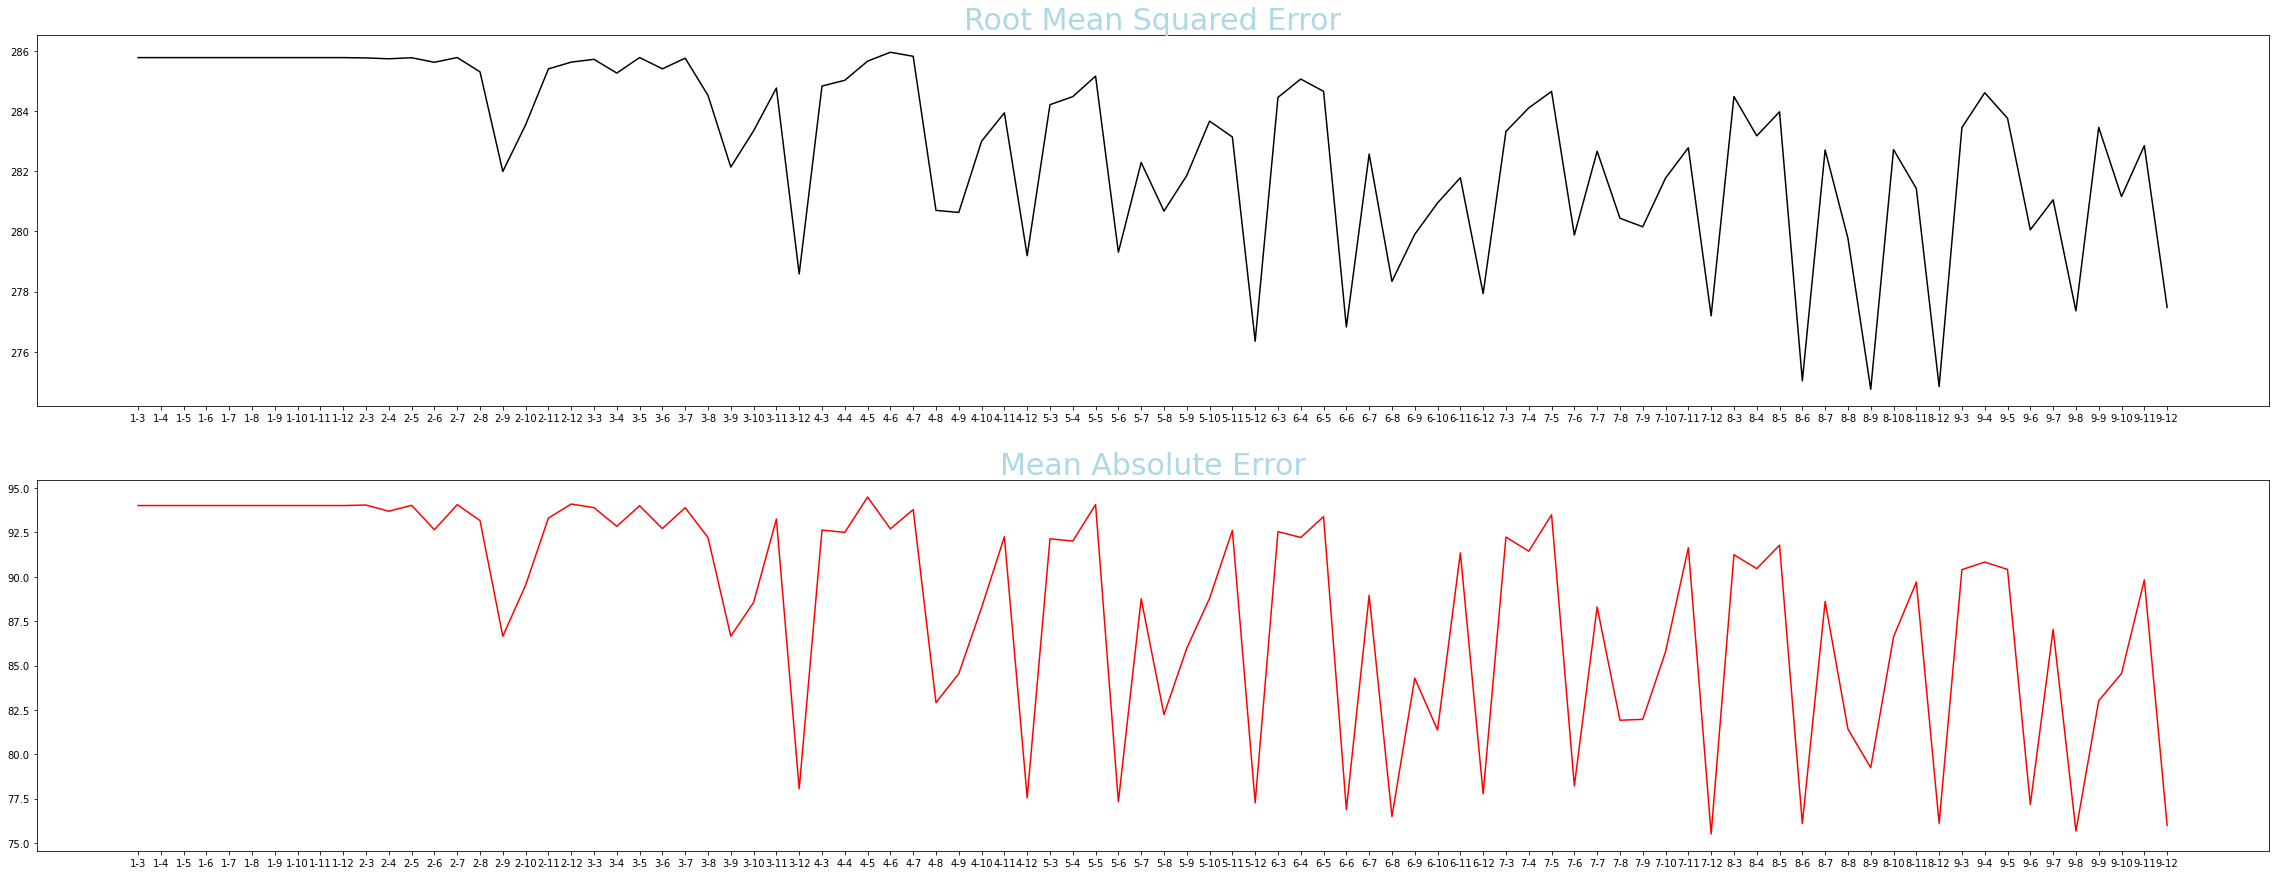

In [ ]:
# plot the results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(40,15))
ax1.plot(x_ticks, rmse_list, color='black', linestyle='solid')
ax2.plot(x_ticks, mae_list, color='red', linestyle='solid')
ax1.set_title('Root Mean Squared Error', fontdict={'fontsize': 30, 'color': 'lightblue'})
ax2.set_title('Mean Absolute Error', fontdict={'fontsize': 30, 'color': 'lightblue'})
plt.show()

As we can see from the plots, we can do much better when we set limitations on our decision tree model. Also, the results we obtained with different max_depth and max_features values are shown in the figures. Wee see that max_depth=8-max_features=12 pair gave us best results, since root mean squared error and meam absolute error are metrics that should be minimized.

### Cross Validation
Now, let's try our chances with cross validation, in case we had unbalanced splits by chance. We will apply 10-Fold cross validation on the models we generate with different hyperparameters.

In [ ]:
# find the best parameter for max_features and max_depth by visualizing the metrics vs max_features
rmse_mean_list = []
rmse_std_list = []
mae_mean_list = []
mae_std_list = []
x_ticks = []
for depth in range(1,10):
  for num_of_features in range (3, 13):
    model = DecisionTreeRegressor(max_depth=depth, max_features=num_of_features, random_state=0)
    rmse_model_accs = cross_val_score(model, x_remaining, y_remaining, cv=10, scoring='neg_root_mean_squared_error',)
    mae_model_accs = cross_val_score(model, x_remaining, y_remaining, cv=10, scoring='neg_mean_absolute_error')
    rmse_mean_list.append((-1)*rmse_model_accs.mean())
    rmse_std_list.append(rmse_model_accs.std())
    mae_mean_list.append((-1)*mae_model_accs.mean())
    mae_std_list.append(mae_model_accs.std())
    x_ticks.append(str(depth) + '-' + str(num_of_features))

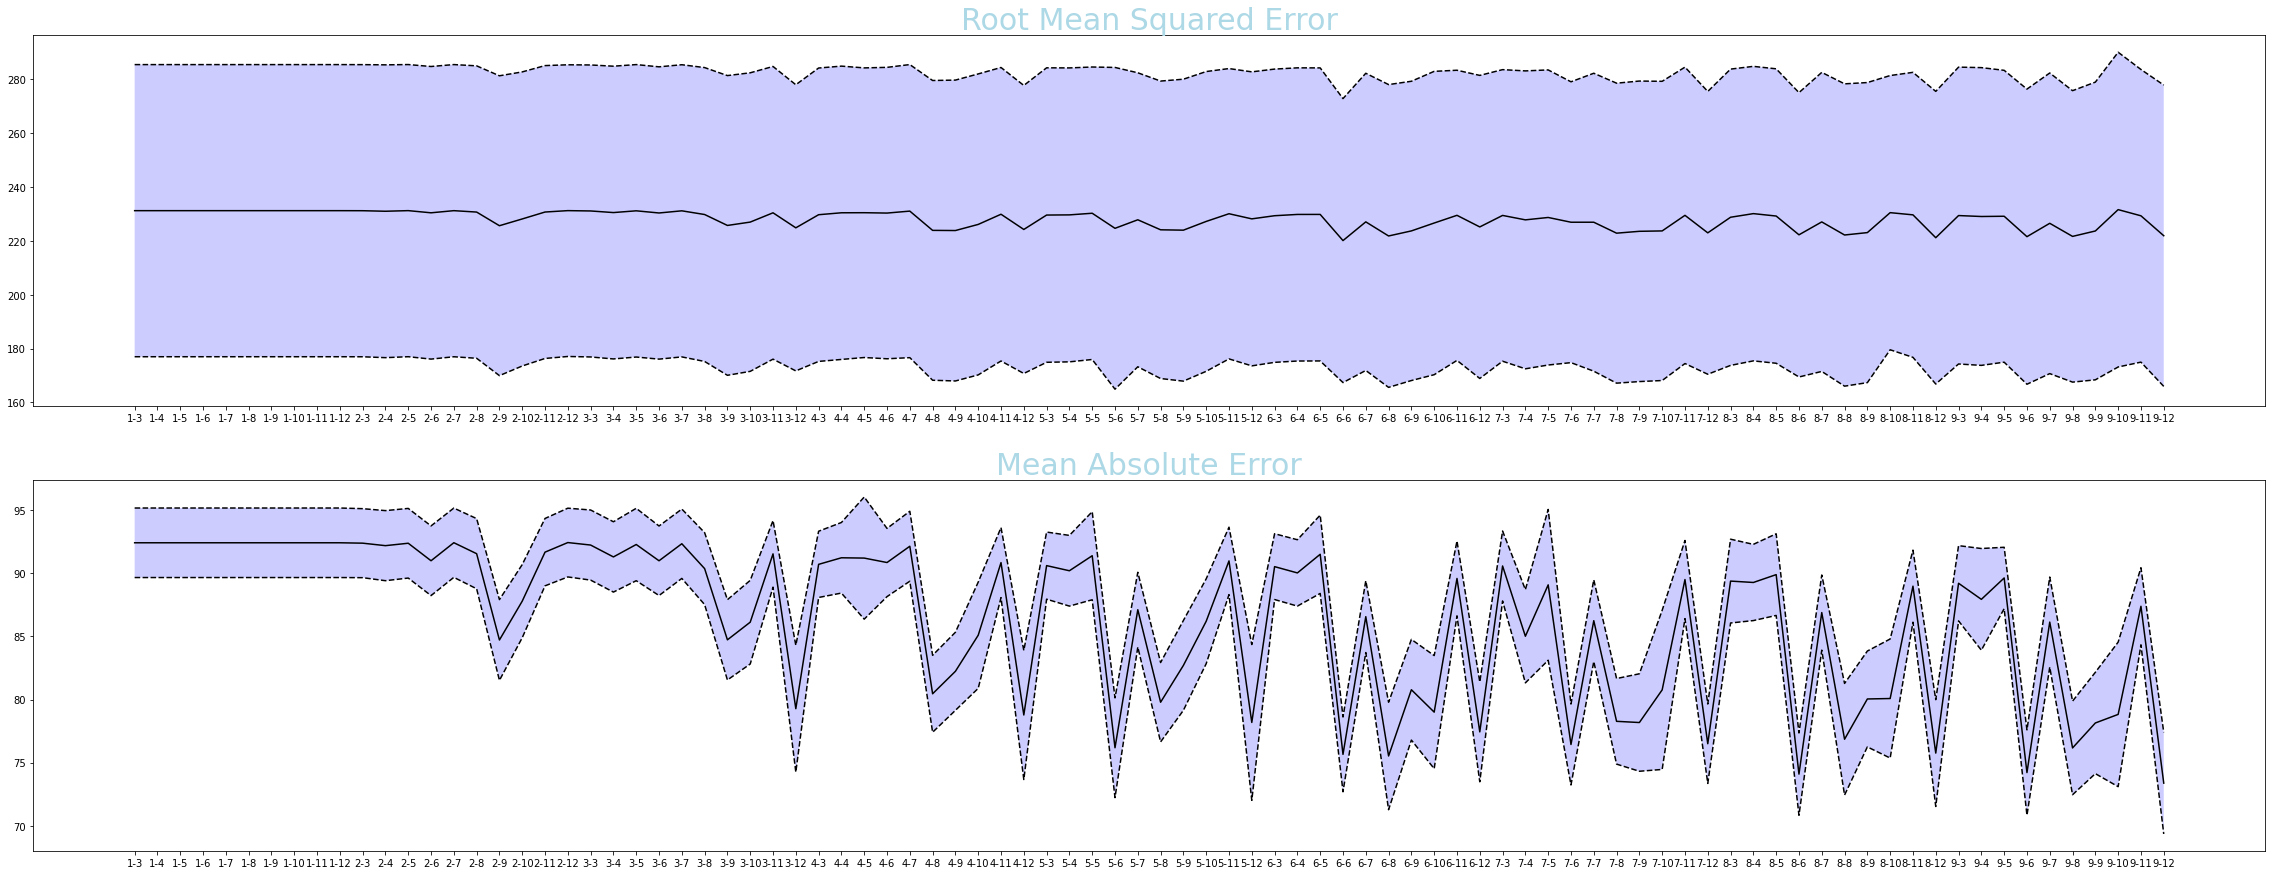

In [ ]:
# plot the results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(40,15))

ax1.plot(x_ticks, rmse_mean_list, color='black', linestyle='solid')
ax1.plot(x_ticks, np.array(rmse_mean_list) + np.array(rmse_std_list),color='black', linestyle='dashed')
ax1.plot(x_ticks, np.array(rmse_mean_list) - np.array(rmse_std_list),color='black', linestyle='dashed' )
ax1.fill_between(x_ticks, np.array(rmse_mean_list) + np.array(rmse_std_list),
                 np.array(rmse_mean_list) - np.array(rmse_std_list), alpha=0.2, facecolor ='b')

ax2.plot(x_ticks, mae_mean_list, color='black', linestyle='solid')
ax2.plot(x_ticks, np.array(mae_mean_list) + np.array(mae_std_list),color='black', linestyle='dashed')
ax2.plot(x_ticks, np.array(mae_mean_list) - np.array(mae_std_list),color='black', linestyle='dashed' )
ax2.fill_between(x_ticks, np.array(mae_mean_list) + np.array(mae_std_list),
                 np.array(mae_mean_list) - np.array(mae_std_list), alpha=0.2, facecolor ='b')

ax1.set_title('Root Mean Squared Error', fontdict={'fontsize': 30, 'color': 'lightblue'})
ax2.set_title('Mean Absolute Error', fontdict={'fontsize': 30, 'color': 'lightblue'})
plt.show()

We may observe from the plots that there are differences between the results we obtained from train-validation-test splits and cross validation. Since cross-validation is more of a trustworthy method, we will move on based on the results we obtained with cross-validation. Setting max_depth to 8 and max_features to 12 gives us good results in both evaluation metrics, so we will go with these hyperparameter values.

In [ ]:
model = DecisionTreeRegressor(max_depth=8, max_features=12)
model.fit(x_train, y_train)
validation_pred = model.predict(x_validation)
mse = mean_squared_error(y_validation, validation_pred)
mae = mean_absolute_error(y_validation, validation_pred)
print('Root Mean Squared Error:', np.sqrt(mse), 'Mean Absolute Error:', mae)

Root Mean Squared Error: 278.8543761307948 Mean Absolute Error: 77.82745182015464


We obtained Root Mean Squared Error as 274.250834049076 and Mean Absolute Error as 72.13029184980373.

## Random Forest

Since decision trees are sensitive to the specific data on which they are trained, they may perform bad on a set of data that they have not been introduced before. Besides, a decision tree cannot go back and make changes after a split is done. Random forests are the solution to these problems. Since several trees, that run independent from each other, are constructed randomly and the predictions of these trees are combined at the end, the possibility of overfitting is highly reduced. Also, the damage of a wrong split in a tree can be compansated by another tree. That's why we are going to use the random forest regression algorithm in this section. 

Since random forest is a costly algorithm, trying all possible values of hyperparameters will consume to much time. To be more practical, this time we are going to do a random search so that we will not try every combination, but select at random to sample a wide range of values. For this purpose, we will utilize the RandomizedSearchCV funtion, which automaticly performs cross validation and decides the best parameters. Let's start by specifying the hypermeter values that our function will work on.

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 300, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(4, 50, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [4, 8, 13, 17, 22, 27, 31, 36, 40, 45, 50, None],
 'max_features': ['auto', 'sqrt', 'log2'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [20, 51, 82, 113, 144, 175, 206, 237, 268, 300]}


Now, we will perform randomized search with 3 folds for each combination. Here, we will specify n_iter, the number of iterations, to 100.

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(x_remaining, y_remaining)
# See the best values of hyperparameters
rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 15.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 30.5min finished


{'bootstrap': False,
 'max_depth': 40,
 'max_features': 'log2',
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 51}

We can see the best parameters from the output. Now, let's construct our model accordingly and see it's performance with our validation data so that we can compare it with the other algorithms.

In [ ]:
# we adjust the hyperparameters accordingly
rf_model = RandomForestRegressor(n_estimators=51, max_depth=40, min_samples_leaf=4, min_samples_split=2, max_features='log2', bootstrap=True)
rf_model.fit(x_train, y_train)
valid_pred = rf_model.predict(x_validation)
rmse = np.sqrt(mean_squared_error(y_validation, valid_pred))
mae = mean_absolute_error(y_validation, valid_pred)
print('Root Mean Squared Error:', rmse, 'Mean Absolute Error:', mae)

Root Mean Squared Error: 268.81138227419194 Mean Absolute Error: 67.7848890414446


We obtained Root Mean Squared Error as 268.81138227419194 and Mean Absolute Error as 67.7848890414446, which are slightly better than decision tree.

In this section, we are going to predict the prices of the rentals in the test split. After that, we will discuss the results and conclude our project. 

In [ ]:
regression_pred = mg_model.predict(x_test)
svm_pred = svr_rbf.predict(x_test)
dt_pred = dt_model.predict(x_test)
rf_pred = rf_model.predict(x_test)

reg_rmse = np.sqrt(mean_squared_error(y_test, regression_pred))
reg_mae = mean_absolute_error(y_test, regression_pred)
svm_rmse = np.sqrt(mean_squared_error(y_test, svm_pred))
svm_mae = mean_absolute_error(y_test, svm_pred)
dt_rmse = np.sqrt(mean_squared_error(y_test, dt_pred))
dt_mae = mean_absolute_error(y_test, dt_pred)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
rf_mae = mean_absolute_error(y_test, rf_pred)

Now, let's compare our predictions with actual prices by visualising them with the help of scatter plots.

In [ ]:
# visualizing the results
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(30,30))
ax1.scatter(y_test, regression_pred)
ax2.scatter(y_test, svm_pred)
ax3.scatter(y_test, dt_pred)
ax4.scatter(y_test, rf_pred)
ax1.set_title('Regression', fontdict={'fontsize': 30, 'color': 'lightblue'})
ax2.set_title('Support Vector Machine', fontdict={'fontsize': 30, 'color': 'lightblue'})
ax3.set_title('Decision Tree', fontdict={'fontsize': 30, 'color': 'lightblue'})
ax4.set_title('Random Forest', fontdict={'fontsize': 30, 'color': 'lightblue'})
plt.show()


| **Error Metric**| Linear Regression | Support Vector Machine | Decision Tree| Random Forest |
| ----------- | ----------- |----------- | ----------- | ----------- |
| ***Root Mean Squared Error***      | 0.7222222222222222       |0.9166666666666666       | 0.9166666666666666       | 0.9166666666666666       |
| ***Mean Absolute Error***   | 0.8055555555555556        |0.9722222222222222        | 0.9722222222222222        | 0.9722222222222222        |
| ***R2***   | 0.8333333333333334        |0.9722222222222222        | 0.9722222222222222        |0.9722222222222222        |


Let's see the root mean squared error and mean absolute error of our predictions on a table.

In [ ]:
results_df = pd.DataFrame{{'Linear Regression': [reg_rmse, reg_mae], 'Support Vector Machine': [svm_rmse, svm_mae], 'Decision Tree': [dt_rmse, dt_mae], 'Random Forest': [rf_rmse, rf_mae]}}
results_df.set_index(['Root Mean Squared Error', 'Mean Absolute Error'])

We see that for all algorithms, the root mean squared error value is higher than mean absolute error. The reason behind could be that RMSE punishes the error harder than MAE. So, the outliers may have confused our models on their predictions.

#Conclusion


We tried to predict the price of a AirBnB house based on the featues of the house and features of the neighborhood. We used several machine learning methods and compared the prediction scores we obtained with each of them, then chose the one that gave us the best results.

In order to decide whether we are successful or unsuccessful in this project, we have to understand the nature of our target variable, price, so that we can have a clearer understanding of what our error rates tell us.

In [ ]:
df.price.describe()

count    48895.000000
mean       152.720687
std        240.154170
min          0.000000
25%         69.000000
50%        106.000000
75%        175.000000
max      10000.000000
Name: price, dtype: float64

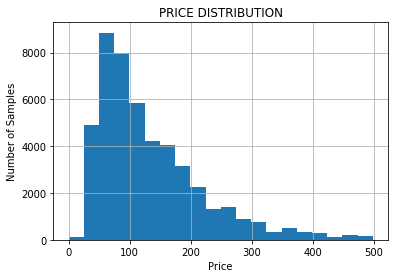

In [ ]:
df[df['price'] < 500].price.hist(bins=20)
plt.title('PRICE DISTRIBUTION')
plt.xlabel('Price')
plt.ylabel('Number of Samples')
plt.show()


If we could have access to some information about the means of transportation oppurtunities nearby the rental's location, we might have achieved even better results. We tried to do the best out of the existing features but more information on rentals could be helpful. Predicting the price is a challenging problem, we did not expect our results to be perfect.

Our project can be used to give the hosts some ideas about the possible pricing of a AirBnB house. It can be also be used to give the renters an idea of the ideal price for a given house which can actually help a lot of people to make financial decisions. Indeed, an algorithm for guessing price is very useful in our modern world. It helps the both sides of any given exchange.